In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("ETH-USDT.csv")
data

,time,open,high,low,close,volume
0,2022-11-01 01:00:00,1569.58,1584.65,1570.03,1581.26,1270.960236
1,2022-11-01 02:00:00,1578.62,1601.25,1581.65,1598.67,1175.210706
2,2022-11-01 03:00:00,1583.70,1604.87,1598.88,1586.67,1179.489195
3,2022-11-01 04:00:00,1580.20,1594.01,1586.92,1589.71,759.581108
4,2022-11-01 05:00:00,1585.10,1596.62,1589.64,1589.79,743.963634
...,...,...,...,...,...,...
2395,2023-02-08 20:00:00,1637.68,1648.84,1646.73,1641.07,259.065503
2396,2023-02-08 21:00:00,1640.53,1655.92,1640.53,1652.77,76.835328
2397,2023-02-08 22:00:00,1650.98,1655.25,1651.72,1650.98,97.828860
2398,2023-02-08 23:00:00,1642.35,1652.85,1651.79,1649.73,247.989693


0.42728107822952716


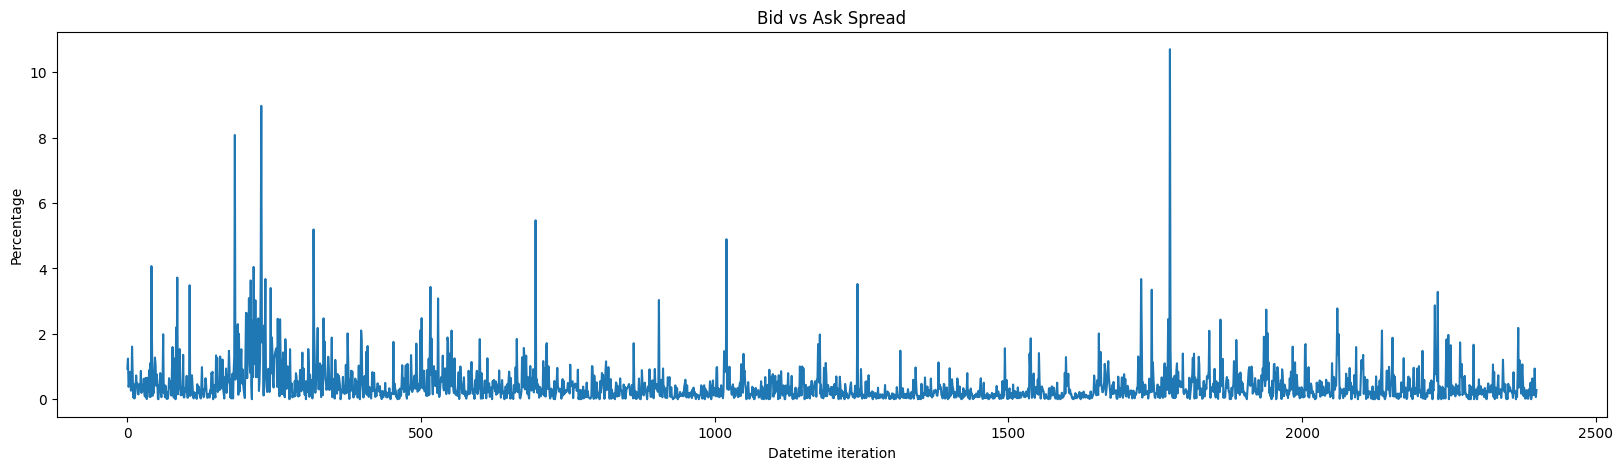

In [3]:
# See the spread
spread_percentage = ((data["high"] - data["low"]) / data["open"]) *1e2
data["spread"] = spread_percentage
average_spread_percentage = np.average(spread_percentage)
print(average_spread_percentage)
plt.figure(figsize=(20,5))
plt.plot(spread_percentage)
plt.title("Bid vs Ask Spread")
plt.xlabel("Datetime iteration")
plt.ylabel("Percentage")
plt.show()

In [4]:
# bollinger bands 
iterations = 18

sma = data["close"].rolling(iterations).mean()
std = data["close"].rolling(iterations).std()
bollinger_upper = sma + std*2
bollinger_lower = sma - std*2

data["simple_mpving_average"] = sma
data["bollinger_upper_band"] = bollinger_upper
data["bollinger_lower_band"] = bollinger_lower


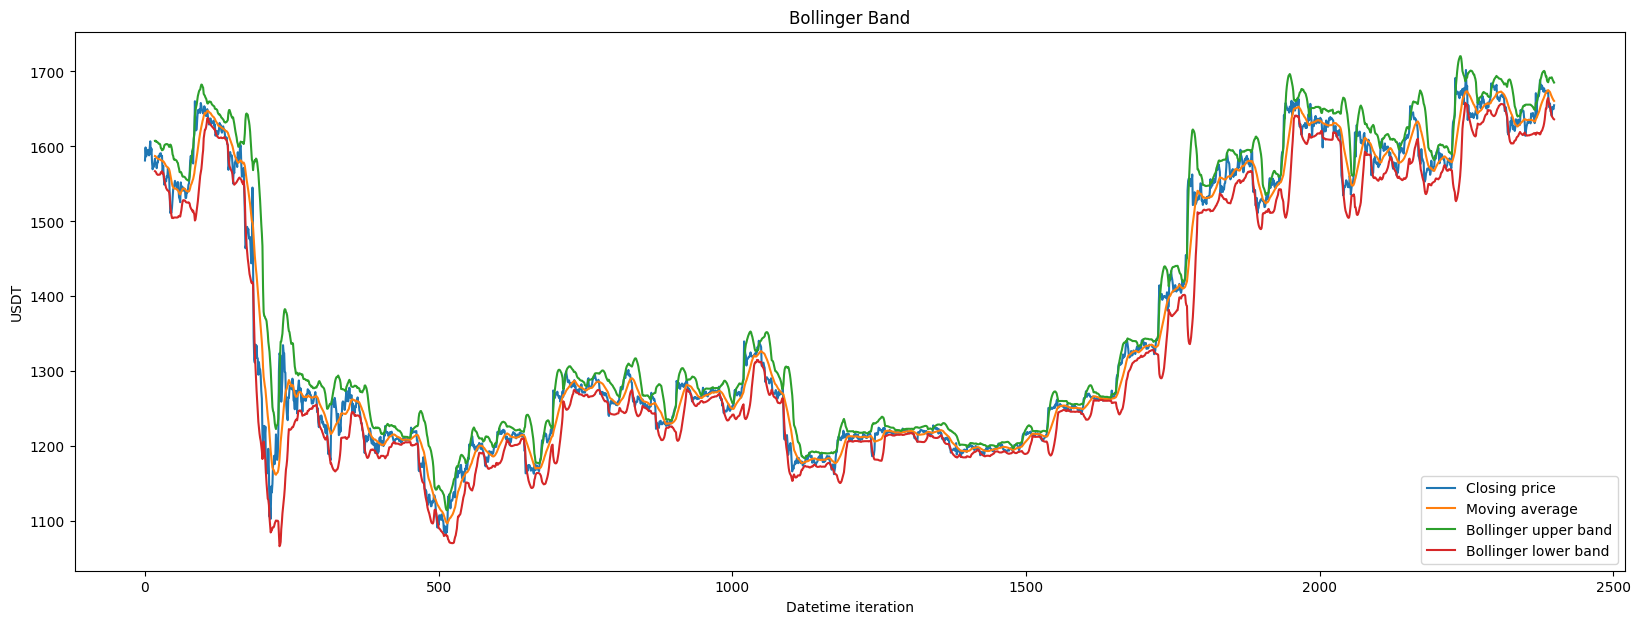

In [5]:
plt.figure(figsize=(20,7))
plt.plot(data["close"], label="Closing price")
plt.plot(data["simple_mpving_average"], label="Moving average")
plt.plot(data["bollinger_upper_band"], label="Bollinger upper band")
plt.plot(data["bollinger_lower_band"], label="Bollinger lower band")
plt.xlabel("Datetime iteration")
plt.ylabel("USDT")
plt.title("Bollinger Band")
plt.legend()
plt.show()

In [6]:
data["bollinger_sell_signal"] = np.where(data["close"] > data["bollinger_upper_band"], 1, 0)
data["bollinger_buy_signal"] = np.where(data["close"] < data["bollinger_lower_band"], 1, 0)
data["bollinger_total_signal"] = data["bollinger_sell_signal"] + -1*data["bollinger_buy_signal"]

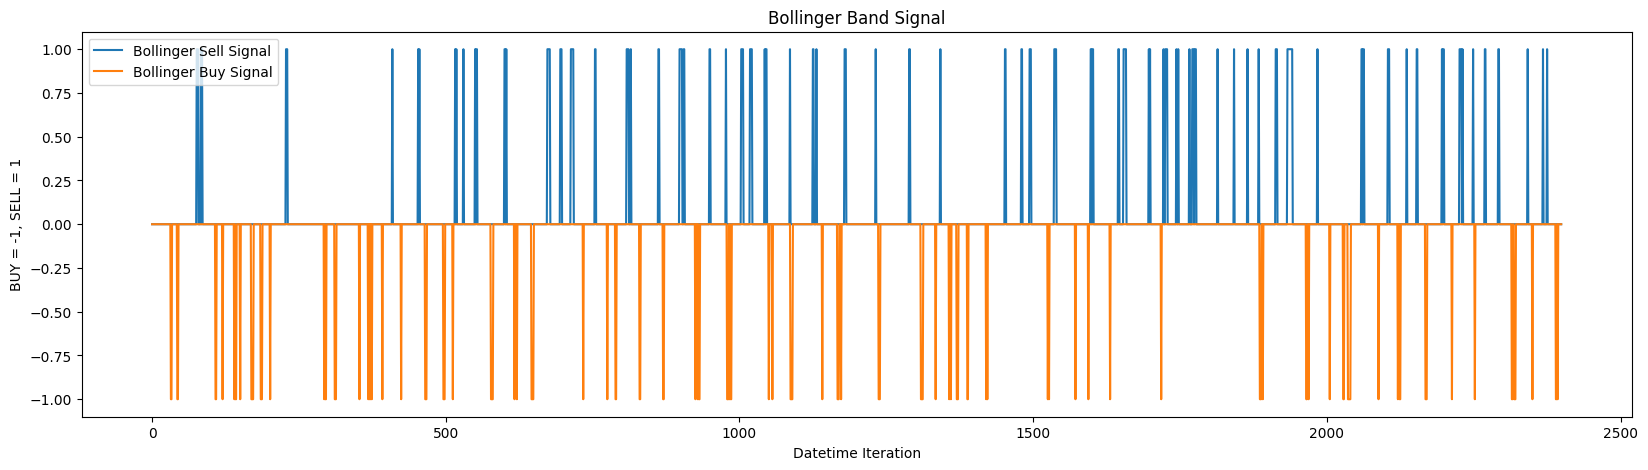

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data["bollinger_sell_signal"], label="Bollinger Sell Signal")
plt.plot(-1*data["bollinger_buy_signal"], label="Bollinger Buy Signal")
# plt.plot(data["bollinger_signal"])
plt.title("Bollinger Band Signal")
plt.xlabel("Datetime Iteration")
plt.ylabel("BUY = -1, SELL = 1")
plt.legend()
plt.show()

In [8]:
# stochastic oscillator
# Define periods
k_period = 14 * 30
d_period = 3 * 30
# Adds a "n_high" column with max value of previous 14 periods
data['n_high'] = data['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
data['n_low'] = data['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['close'] - data['n_low']) * 100 / (data['n_high'] - data['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
data['%D'] = data['%K'].rolling(d_period).mean()

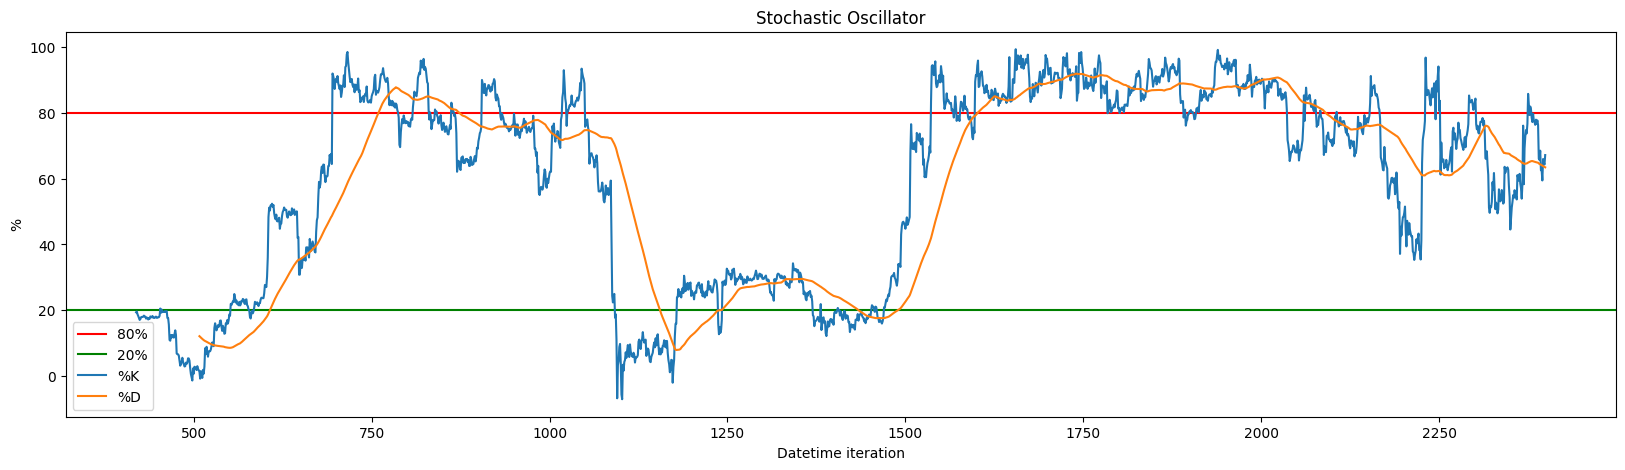

In [9]:
plt.figure(figsize=(20,5))
plt.axhline(y=80, color="r", label="80%")
plt.axhline(y=20, color="g", label="20%")
plt.plot(data['%K'], label="%K")
plt.plot(data['%D'], label="%D")
plt.title("Stochastic Oscillator")
plt.xlabel("Datetime iteration")
plt.ylabel("%")
plt.legend()
plt.show()

In [10]:
data["K80"] = np.where(data["%K"] > 80, 1, 0)
data["D80"] = np.where(data["%D"] > 80, 1, 0)
data["K20"] = np.where(data["%K"] < 20, 1, 0)
data["D20"] = np.where(data["%D"] < 20, 1, 0)

data["K80D80"] = data["K80"] * data["D80"]
data["K20D20"] = data["K20"] * data["D20"]

data["%K>%D"] = np.where(data["%K"] > data["%D"], 1, 0)
data["%K<%D"] = np.where(data["%K"] < data["%D"], 1, 0)

# overbrought state
data["stochastic_oscillator_sell_signal"] = np.where(data["K80D80"] > 0, data["%K>%D"], 0)
# oversold state
data["stochastic_oscillator_buy_signal"] = np.where(data["K20D20"] > 0, data["%K<%D"], 0)

data["stochastic_oscillator_total_signal"] = data["stochastic_oscillator_sell_signal"] + -1 * data["stochastic_oscillator_buy_signal"]

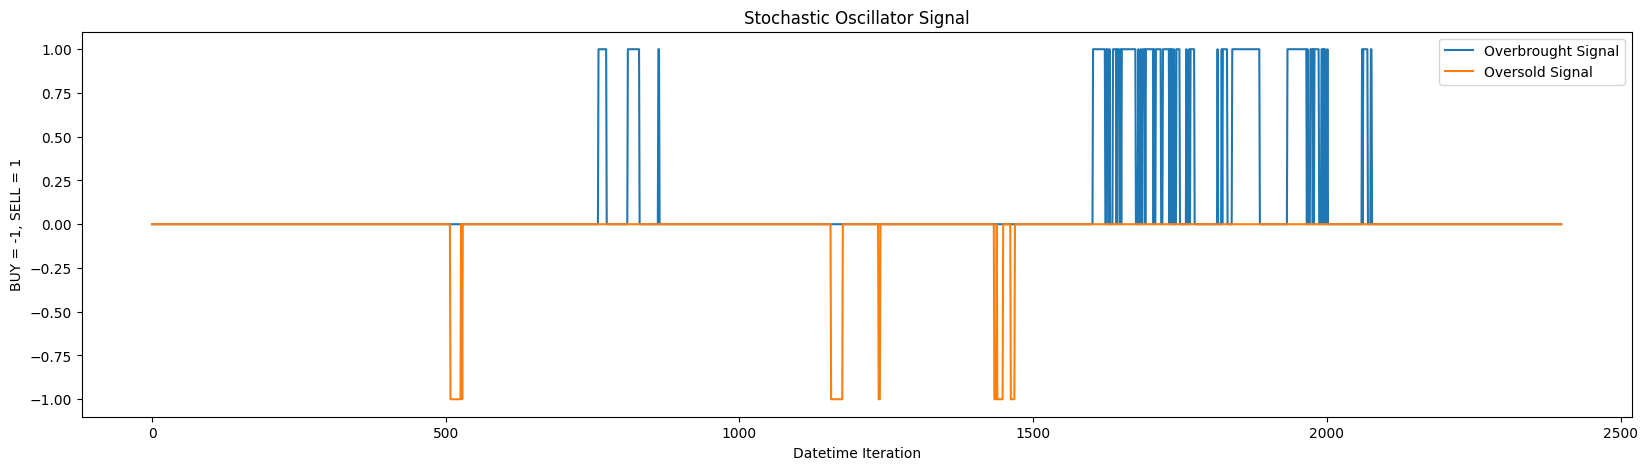

In [11]:
plt.figure(figsize=(20,5))
plt.plot(data["stochastic_oscillator_sell_signal"], label="Overbrought Signal")
plt.plot(-1*data["stochastic_oscillator_buy_signal"], label="Oversold Signal")
# plt.plot(data["stochastic_oscillator_total_signal"])
plt.title("Stochastic Oscillator Signal")
plt.xlabel("Datetime Iteration")
plt.ylabel("BUY = -1, SELL = 1")
plt.legend()
plt.show()

In [12]:
buy_signal = data["bollinger_sell_signal"] * -1*data["D20"]
sell_signal = data["bollinger_buy_signal"] * 1*data["K80"]

data["my_signal"] = buy_signal + sell_signal

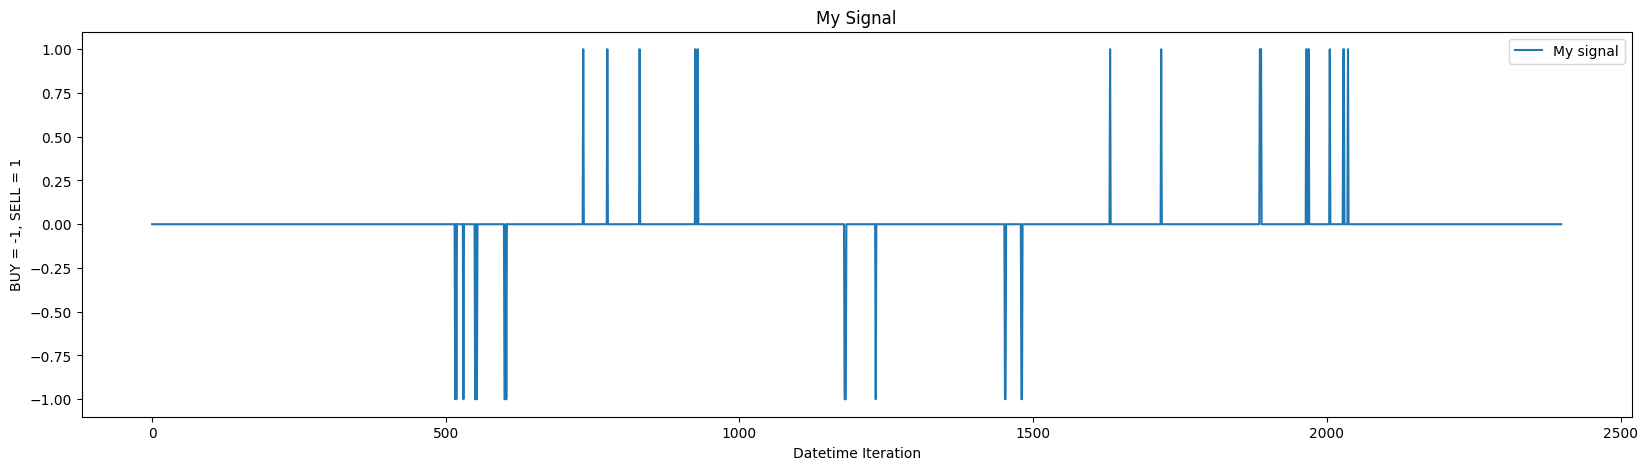

In [13]:
plt.figure(figsize=(20,5))
plt.plot(data["my_signal"], label="My signal")
plt.title("My Signal")
plt.xlabel("Datetime Iteration")
plt.ylabel("BUY = -1, SELL = 1")
plt.legend()
plt.show()

Total number of trades: 34


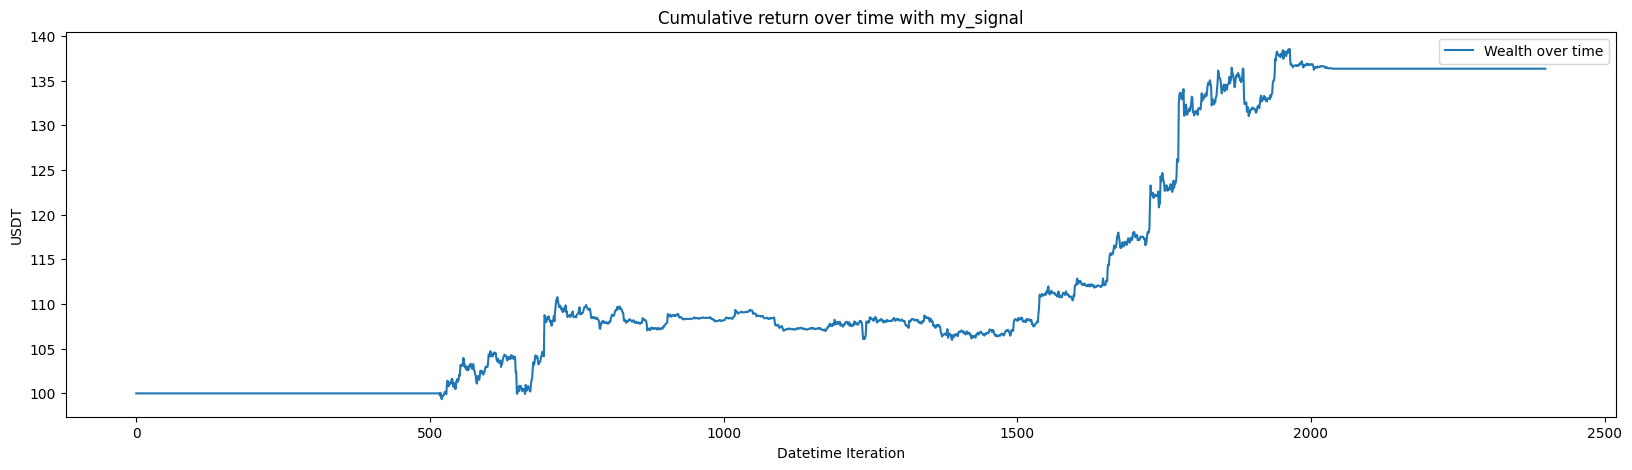

In [14]:
def runSimulation(data, strategy):
    # order attributes of (price, position)
    open_orders = []

    # portfolio
    starting_portfolio = 100
    trade_size = 0.25
    cutoff_trading = 10
    cumulative_return = []
    numTrades = 0
    for i in range(len(data)):

        current_data = data.iloc[i]      

        # Sell order 
        if current_data[strategy] == 1:
            if len(open_orders) > 0:
                buy_price, buy_position = open_orders[0]
                del open_orders[0]
                sell_price = current_data['close']
                pnl = sell_price * buy_position
                starting_portfolio = starting_portfolio + pnl
                numTrades += 1
        # Buy order
        if current_data[strategy] == -1:
            if starting_portfolio > cutoff_trading:
                pending_orders = [open_orders[i][0]*open_orders[i][1] for i in range(len(open_orders))]
                buy_price = current_data['close']
                buy_position = starting_portfolio * trade_size / buy_price
                starting_portfolio = starting_portfolio - buy_position * buy_price
                open_orders.append((buy_price, buy_position))
                numTrades += 1

        pending_orders = [current_data["close"]*open_orders[i][1] for i in range(len(open_orders))]
        cumulative_return.append(starting_portfolio + sum(pending_orders))

    print("Total number of trades:", numTrades)
    plt.figure(figsize=(20,5))
    plt.plot(cumulative_return, label="Wealth over time")
    plt.legend()
    plt.xlabel("Datetime Iteration")
    plt.ylabel("USDT")
    plt.title("Cumulative return over time with {}".format(strategy))
    plt.show()

runSimulation(data, "my_signal")

Total number of trades: 36


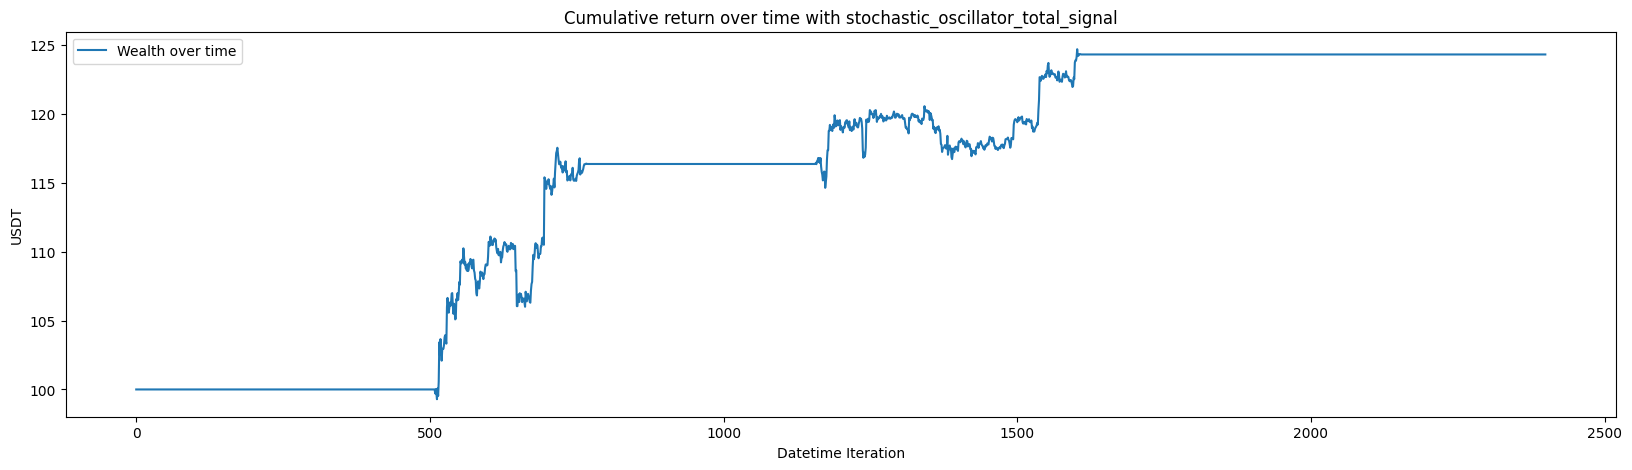

In [15]:
runSimulation(data, "stochastic_oscillator_total_signal")

Total number of trades: 212


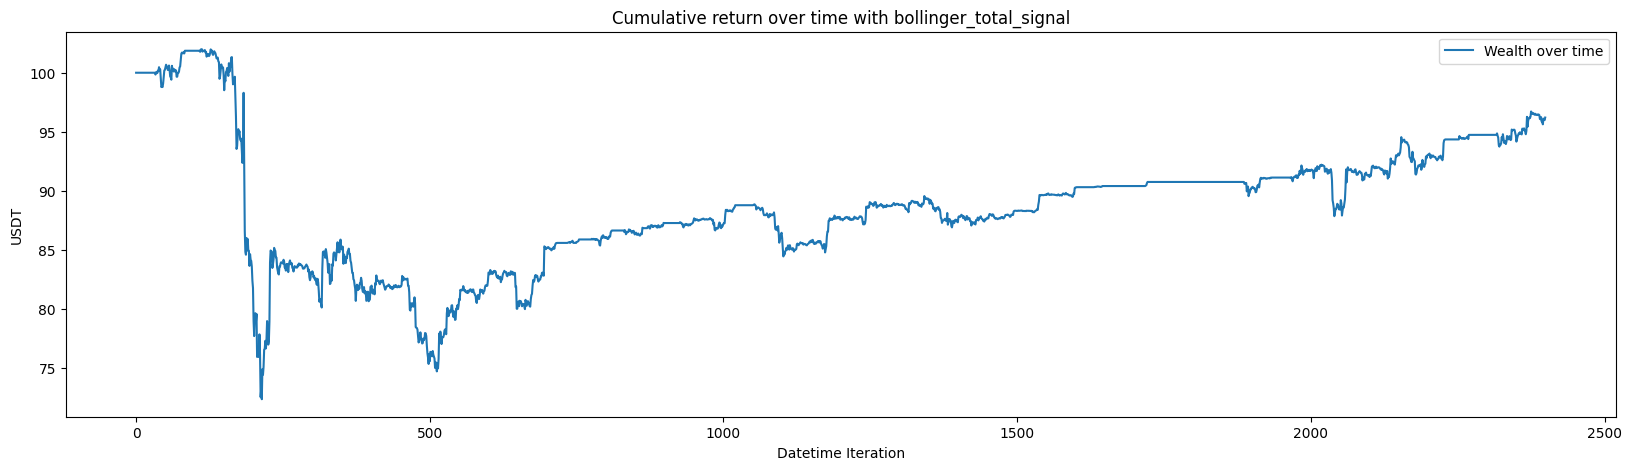

In [16]:
runSimulation(data, "bollinger_total_signal")